In [8]:
!pip install --upgrade transformers --quiet


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


!pip install torch torchvision torchaudio
!pip install monai
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm
from tqdm import tqdm


In [2]:
!which python

/Users/spartan/Desktop/desktop/USA/2 Sem/258/hw/cmpe258/bin/python


In [1]:
import os, time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from monai.transforms import LoadImage
from PIL import Image
import matplotlib.pyplot as plt


/Users/spartan/Desktop/desktop/USA/2 Sem/258/hw/cmpe258/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MedNISTDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_tensor = LoadImage(image_only=True)(self.image_paths[idx])
    
        # Convert MetaTensor -> NumPy array (strip metadata)
        img_array = img_tensor.asnumpy() if hasattr(img_tensor, "asnumpy") else img_tensor.detach().cpu().numpy()
    
        # Ensure shape is [H, W] for grayscale images
        if img_array.ndim == 3 and img_array.shape[0] == 1:
            img_array = img_array[0]  # Remove the single channel dim
    
        # Convert NumPy to PIL image
        img = Image.fromarray((img_array * 255).astype("uint8"))
    
        if self.transform:
            img = self.transform(img)
    
        return img, self.labels[idx]



In [3]:
root_dir = "./data/MedNIST"
classes = sorted(os.listdir(root_dir))
image_files, labels = [], []

for label, class_name in enumerate(classes):
    class_path = os.path.join(root_dir, class_name)
    if not os.path.isdir(class_path): continue
    for file in os.listdir(class_path):
        image_files.append(os.path.join(class_path, file))
        labels.append(label)

train_x, test_x, train_y, test_y = train_test_split(image_files, labels, test_size=0.2, random_state=42)



In [4]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_ds = MedNISTDataset(train_x, train_y, transform=train_transform)
test_ds = MedNISTDataset(test_x, test_y, transform=test_transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*16*16, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SimpleCNN(num_classes=len(classes)).to(device)


In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
criterion = nn.CrossEntropyLoss()


In [26]:
def train(model, loader, optimizer, scheduler, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            torch.mps.synchronize()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"✅ Epoch [{epoch+1}/{epochs}] — Loss: {total_loss/len(loader):.4f}")

train(model, train_loader, optimizer, scheduler)


✅ Epoch [1/5] — Loss: 0.0459
✅ Epoch [2/5] — Loss: 0.0086
✅ Epoch [3/5] — Loss: 0.0064
✅ Epoch [4/5] — Loss: 0.0017
✅ Epoch [5/5] — Loss: 0.0006


In [7]:
model.load_state_dict(torch.load("custom_cnn.pth"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)

In [27]:
torch.save(model.state_dict(), "custom_cnn.pth")
print("💾 Model saved as custom_cnn.pth")


💾 Model saved as baseline_model.pth


In [8]:

def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            preds = model(data).argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    return 100 * correct / total

acc = evaluate(model, test_loader)
print(f"📊 Accuracy: {acc:.2f}%")


📊 Accuracy: 99.97%


In [9]:
def measure_inference(model, loader):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            _ = model(data)
    return time.time() - start

inf_time = measure_inference(model, test_loader)
print(f"⏱️ Inference Time: {inf_time:.2f} seconds")


⏱️ Inference Time: 23.01 seconds


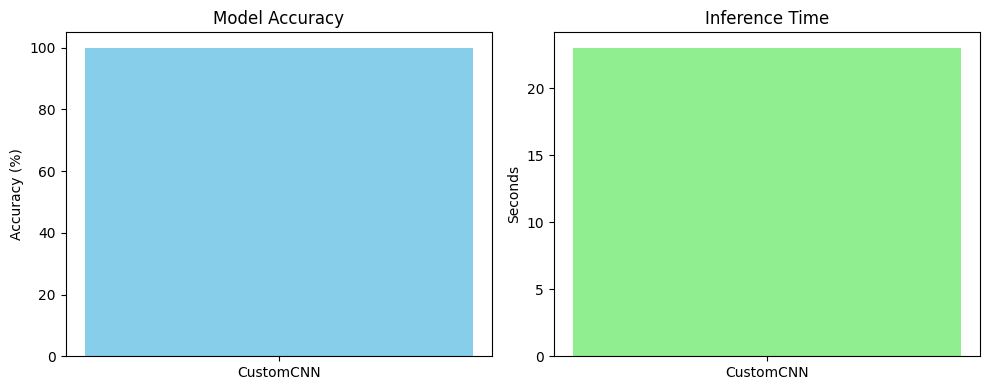

In [10]:
import matplotlib.pyplot as plt

# If you're just plotting one model for now
models = ["CustomCNN"]
accuracies = [acc]
inference_times = [inf_time]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color='skyblue')
plt.title("Model Accuracy")
plt.ylabel("Accuracy (%)")

plt.subplot(1, 2, 2)
plt.bar(models, inference_times, color='lightgreen')
plt.title("Inference Time")
plt.ylabel("Seconds")

plt.tight_layout()
plt.show()


In [3]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split


In [4]:
root_dir = "./data/MedNIST"
assert os.path.exists(root_dir), "MedNIST folder not found in ./data/"

classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
image_files, labels = [], []
for label, class_name in enumerate(classes):
    class_path = os.path.join(root_dir, class_name)
    for img_file in os.listdir(class_path):
        image_files.append(os.path.join(class_path, img_file))
        labels.append(label)

train_x, test_x, train_y, test_y = train_test_split(image_files, labels, test_size=0.2, random_state=42, stratify=labels)

#  4. Define Custom Dataset Class
class MedNISTDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

#  5. Transforms and DataLoaders
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 👈 this is the fix
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Match 3 channels
])


train_ds = MedNISTDataset(train_x, train_y, transform=transform)
test_ds = MedNISTDataset(test_x, test_y, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# 6. Select Apple M1/M2 MPS backend (before model definition!)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple Silicon MPS backend")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, using CPU")

# 7. Define Teacher and Student Models
teacher_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
teacher_model.fc = nn.Linear(512, len(classes))
teacher_model.to(device)

student_model = models.mobilenet_v2(weights=None)
student_model.classifier[1] = nn.Linear(1280, len(classes))
student_model.to(device)




✅ Using Apple Silicon MPS backend


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
# ✅ Move teacher to CPU to reduce GPU load (MPS is picky)
teacher_model.to("cpu")
student_model.to(device)

# ✅ Reduce dataset size for quick testing
train_x = train_x[:1000]
train_y = train_y[:1000]
train_ds = MedNISTDataset(train_x, train_y, transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# ✅ Simple training loop for distillation (no tqdm)
def train_distillation(teacher, student, train_loader, optimizer, epochs=2, temperature=4.0, alpha=0.5):
    criterion_ce = nn.CrossEntropyLoss()
    criterion_kd = nn.KLDivLoss(reduction='batchmean')
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            with torch.no_grad():
                teacher_logits = teacher(data.to("cpu"))  # teacher runs on CPU
                teacher_logits = teacher_logits.to(device)  # ✅ bring it to MPS for loss
            student_logits = student(data)

            loss_ce = criterion_ce(student_logits, target)
            loss_kd = criterion_kd(
                F.log_softmax(student_logits / temperature, dim=1),
                F.softmax(teacher_logits / temperature, dim=1)
            )
            loss = alpha * loss_ce + (1 - alpha) * loss_kd

            optimizer.zero_grad()
            loss.backward()
            torch.mps.synchronize()  # important for MPS devices
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

        print(f"✅ Epoch [{epoch+1}/{epochs}] — Avg Loss: {total_loss / len(train_loader):.4f}")

# ✅ Run training
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
train_distillation(teacher_model, student_model, train_loader, optimizer, epochs=2)


Epoch 1, Batch 0, Loss: 0.9381
Epoch 1, Batch 10, Loss: 0.8015
Epoch 1, Batch 20, Loss: 0.7407
Epoch 1, Batch 30, Loss: 0.6771
✅ Epoch [1/2] — Avg Loss: 0.7788
Epoch 2, Batch 0, Loss: 0.6890
Epoch 2, Batch 10, Loss: 0.6015
Epoch 2, Batch 20, Loss: 0.4804
Epoch 2, Batch 30, Loss: 0.5219
✅ Epoch [2/2] — Avg Loss: 0.5647


In [6]:
# ✅ Evaluation function
def evaluate_model(model, loader):
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

# ✅ Evaluate both models
teacher_model.to(device)
acc_teacher = evaluate_model(teacher_model, test_loader)
acc_student = evaluate_model(student_model, test_loader)

print(f"Teacher Accuracy: {acc_teacher:.2f}%")
print(f"Student Accuracy: {acc_student:.2f}%")

# ✅ Inference time comparison
def measure_inference_time(model, loader):
    model.eval()
    model.to(device)
    start = time.time()
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            _ = model(data)
    return time.time() - start

inference_time_teacher = measure_inference_time(teacher_model, test_loader)
inference_time_student = measure_inference_time(student_model, test_loader)
print(f"Inference Time - Teacher: {inference_time_teacher:.2f}s")
print(f"Inference Time - Student: {inference_time_student:.2f}s")


Teacher Accuracy: 21.82%
Student Accuracy: 16.96%
Inference Time - Teacher: 20.48s
Inference Time - Student: 20.28s


In [32]:
torch.save(model.state_dict(), "custom_cnn.pth")


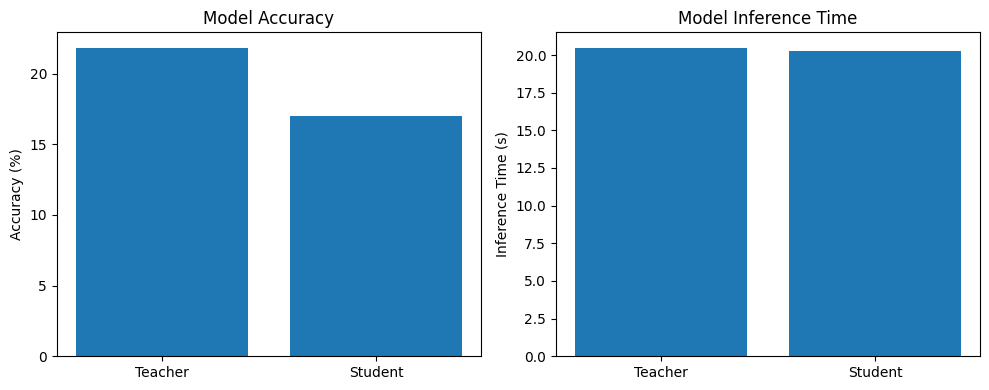

In [7]:

# ✅ Plot results
labels = ["Teacher", "Student"]
accuracies = [acc_teacher, acc_student]
times = [inference_time_teacher, inference_time_student]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, accuracies)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.bar(labels, times)
plt.ylabel("Inference Time (s)")
plt.title("Model Inference Time")
plt.tight_layout()
plt.show()